In [ ]:
# 1 Imports
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
import matplotlib.pyplot as plt

In [10]:
# 2 Load Datasets
df_nlr = pd.read_csv("raw_nuclear/nlr.csv")
df_ura = pd.read_csv("raw_nuclear/ura.csv")
df_crak = pd.read_csv("raw_oil_and_gas/crak.csv")
df_fcg = pd.read_csv("raw_oil_and_gas/fcg.csv")
df_pxe = pd.read_csv("raw_oil_and_gas/pxe.csv")
df_icln = pd.read_csv("raw_renewable/icln.csv")
df_smog = pd.read_csv("raw_renewable/smog.csv")
df_tan = pd.read_csv("raw_renewable/tan.csv")

repaired_col = "Repaired?"
df_nlr = df_nlr.drop(columns=[repaired_col]).fillna(0)
df_ura = df_ura.drop(columns=[repaired_col]).fillna(0)
df_crak = df_crak.drop(columns=[repaired_col]).fillna(0)
df_fcg = df_fcg.drop(columns=[repaired_col]).fillna(0)
df_pxe = df_pxe.drop(columns=[repaired_col]).fillna(0)
df_icln = df_icln.drop(columns=[repaired_col]).fillna(0)
df_smog = df_smog.drop(columns=[repaired_col]).fillna(0)
df_tan = df_tan.drop(columns=[repaired_col]).fillna(0)

df_nlr = df_nlr.drop(columns=["Date"]).fillna(0)
df_ura = df_ura.drop(columns=["Date"]).fillna(0)
df_crak = df_crak.drop(columns=["Date"]).fillna(0)
df_fcg = df_fcg.drop(columns=["Date"]).fillna(0)
df_pxe = df_pxe.drop(columns=["Date"]).fillna(0)
df_icln = df_icln.drop(columns=["Date"]).fillna(0)
df_smog = df_smog.drop(columns=["Date"]).fillna(0)
df_tan = df_tan.drop(columns=["Date"]).fillna(0)

df_combined_nuclear = np.concatenate((df_nlr, df_ura))
df_combined_oilgas = np.concatenate((df_crak, df_fcg, df_pxe))
df_combined_renewable = np.concatenate((df_icln, df_smog, df_tan))

df_nlr_close = df_nlr[["Close"]]
df_ura_close = df_ura[["Close"]]
df_crak_close = df_crak[["Close"]]
df_fcg_close = df_fcg[["Close"]]
df_pxe_close = df_pxe[["Close"]]
df_icln_close = df_icln[["Close"]]
df_smog_close = df_smog[["Close"]]
df_tan_close = df_tan[["Close"]]

df_nuclear_close = df_combined_nuclear[:,3]
df_oilgas_close = df_combined_oilgas[:,3]
df_renewable_close = df_combined_renewable[:,3]

In [15]:
# 3 Create time frame based subsets
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

def time_based_subsets(df):
    subsets = []
    #row 2013 is the last date of 2023, 12/29/2023
    #row 756 is start of 2019
    #row 505 is start of 2018
    #row 254 is start of 2017
    #row 2 is start of 2016
    #all of these -2 bc 0 indexing and bc title row already seperated out in pd df
    subsets.append(df[0:2012]) #8 year time frame
    subsets.append(df[252:2012]) #7 year time frame
    subsets.append(df[503:2012]) #6 year time frame
    subsets.append(df[754:2012]) #5 year time frame
    subsets.append(df[2012:2262]) # 2024 only
    X, y = [], []
    x1, y1 = create_sequences(subsets[0], 30)
    x1 = x1.reshape((x1.shape[0], x1.shape[1]))
    x2, y2 = create_sequences(subsets[1], 30)
    x2 = x2.reshape((x2.shape[0], x2.shape[1]))
    x3, y3 = create_sequences(subsets[2], 30)
    x3 = x3.reshape((x3.shape[0], x3.shape[1]))
    x4, y4 = create_sequences(subsets[3], 30)
    x4 = x4.reshape((x4.shape[0], x4.shape[1]))
    x5, y5 = create_sequences(subsets[4], 30)
    x5 = x5.reshape((x5.shape[0], x5.shape[1]))
    X.append(x1)
    X.append(x2)
    X.append(x3)
    X.append(x4)
    X.append(x5)
    y.append(y1)
    y.append(y2)
    y.append(y3)
    y.append(y4)
    y.append(y5)
    return subsets, X, y

scaler1 = StandardScaler()
scaled_nlr_close = scaler1.fit_transform(df_nlr_close)
nlr_sets, nlr_X, nlr_y = time_based_subsets(scaled_nlr_close)
scaler2 = StandardScaler()
scaled_ura_close = scaler2.fit_transform(df_ura_close)
ura_sets, ura_X, ura_y = time_based_subsets(scaled_ura_close)
scaler3 = StandardScaler()
scaled_crak_close = scaler3.fit_transform(df_crak_close)
crak_sets, crak_X, crak_y = time_based_subsets(scaled_crak_close)
scaler4 = StandardScaler()
scaled_fcg_close = scaler4.fit_transform(df_fcg_close)
fcg_sets, fcg_X, fcg_y = time_based_subsets(scaled_fcg_close)
scaler5 = StandardScaler()
scaled_pxe_close = scaler5.fit_transform(df_pxe_close)
pxe_sets, pxe_X, pxe_y = time_based_subsets(scaled_pxe_close)
scaler6 = StandardScaler()
scaled_icln_close = scaler6.fit_transform(df_icln_close)
icln_sets, icln_X, icln_y = time_based_subsets(scaled_icln_close)
scaler7 = StandardScaler()
scaled_smog_close = scaler7.fit_transform(df_smog_close)
smog_sets, smog_X, smog_y = time_based_subsets(scaled_smog_close)
scaler8 = StandardScaler()
scaled_tan_close = scaler8.fit_transform(df_tan_close)
tan_sets, tan_X, tan_y = time_based_subsets(scaled_tan_close)

scaler_nuclear = StandardScaler()
scaled_nuclear = scaler_nuclear.fit_transform(df_nuclear_close.reshape(-1,1))
nuclear_nlr = scaler_nuclear.transform(df_nlr_close)
nuclear_ura = scaler_nuclear.transform(df_ura_close)
nuclear_nlr_sets, nuclear_nlr_X, nuclear_nlr_y = time_based_subsets(nuclear_nlr)
nuclear_ura_sets, nuclear_ura_X, nuclear_ura_y = time_based_subsets(nuclear_ura)
combined_nuclear_X, combined_nuclear_y = [], []
combined_nuclear_X.append(np.concatenate((nuclear_nlr_X[0], nuclear_ura_X[0])))
combined_nuclear_X.append(np.concatenate((nuclear_nlr_X[1], nuclear_ura_X[1])))
combined_nuclear_X.append(np.concatenate((nuclear_nlr_X[2], nuclear_ura_X[2])))
combined_nuclear_X.append(np.concatenate((nuclear_nlr_X[3], nuclear_ura_X[3])))
combined_nuclear_X.append(np.concatenate((nuclear_nlr_X[4], nuclear_ura_X[4])))
combined_nuclear_y.append(np.concatenate((nuclear_nlr_y[0], nuclear_ura_y[0])))
combined_nuclear_y.append(np.concatenate((nuclear_nlr_y[1], nuclear_ura_y[1])))
combined_nuclear_y.append(np.concatenate((nuclear_nlr_y[2], nuclear_ura_y[2])))
combined_nuclear_y.append(np.concatenate((nuclear_nlr_y[3], nuclear_ura_y[3])))
combined_nuclear_y.append(np.concatenate((nuclear_nlr_y[4], nuclear_ura_y[4])))

scaler_oilgas = StandardScaler()
scaled_oilgas = scaler_oilgas.fit_transform(df_oilgas_close.reshape(-1,1))
oilgas_crak = scaler_oilgas.transform(df_crak_close)
oilgas_fcg = scaler_oilgas.transform(df_fcg_close)
oilgas_pxe = scaler_oilgas.transform(df_pxe_close)
oilgas_crak_sets, oilgas_crak_X, oilgas_crak_y = time_based_subsets(oilgas_crak)
oilgas_fcg_sets, oilgas_fcg_X, oilgas_fcg_y = time_based_subsets(oilgas_fcg)
oilgas_pxe_sets, oilgas_pxe_X, oilgas_pxe_y = time_based_subsets(oilgas_pxe)
combined_oilgas_X, combined_oilgas_y = [], []
combined_oilgas_X.append(np.concatenate((oilgas_crak_X[0], oilgas_fcg_X[0], oilgas_pxe_X[0])))
combined_oilgas_X.append(np.concatenate((oilgas_crak_X[1], oilgas_fcg_X[1], oilgas_pxe_X[1])))
combined_oilgas_X.append(np.concatenate((oilgas_crak_X[2], oilgas_fcg_X[2], oilgas_pxe_X[2])))
combined_oilgas_X.append(np.concatenate((oilgas_crak_X[3], oilgas_fcg_X[3], oilgas_pxe_X[3])))
combined_oilgas_X.append(np.concatenate((oilgas_crak_X[4], oilgas_fcg_X[4], oilgas_pxe_X[4])))
combined_oilgas_y.append(np.concatenate((oilgas_crak_y[0], oilgas_fcg_y[0], oilgas_pxe_y[0])))
combined_oilgas_y.append(np.concatenate((oilgas_crak_y[1], oilgas_fcg_y[1], oilgas_pxe_y[1])))
combined_oilgas_y.append(np.concatenate((oilgas_crak_y[2], oilgas_fcg_y[2], oilgas_pxe_y[2])))
combined_oilgas_y.append(np.concatenate((oilgas_crak_y[3], oilgas_fcg_y[3], oilgas_pxe_y[3])))
combined_oilgas_y.append(np.concatenate((oilgas_crak_y[4], oilgas_fcg_y[4], oilgas_pxe_y[4])))


scaler_renewable = StandardScaler()
scaled_renewable = scaler_renewable.fit_transform(df_renewable_close.reshape(-1,1))
renewable_icln = scaler_renewable.transform(df_icln_close)
renewable_smog = scaler_renewable.transform(df_smog_close)
renewable_tan = scaler_renewable.transform(df_tan_close)
renewable_icln_sets, renewable_icln_X, renewable_icln_y = time_based_subsets(renewable_icln)
renewable_smog_sets, renewable_smog_X, renewable_smog_y = time_based_subsets(renewable_smog)
renewable_tan_sets, renewable_tan_X, renewable_tan_y = time_based_subsets(renewable_tan)
combined_renewable_X, combined_renewable_y = [], []
combined_renewable_X.append(np.concatenate((renewable_icln_X[0], renewable_smog_X[0], renewable_tan_X[0])))
combined_renewable_X.append(np.concatenate((renewable_icln_X[1], renewable_smog_X[1], renewable_tan_X[1])))
combined_renewable_X.append(np.concatenate((renewable_icln_X[2], renewable_smog_X[2], renewable_tan_X[2])))
combined_renewable_X.append(np.concatenate((renewable_icln_X[3], renewable_smog_X[3], renewable_tan_X[3])))
combined_renewable_X.append(np.concatenate((renewable_icln_X[4], renewable_smog_X[4], renewable_tan_X[4])))
combined_renewable_y.append(np.concatenate((renewable_icln_y[0], renewable_smog_y[0], renewable_tan_y[0])))
combined_renewable_y.append(np.concatenate((renewable_icln_y[1], renewable_smog_y[1], renewable_tan_y[1])))
combined_renewable_y.append(np.concatenate((renewable_icln_y[2], renewable_smog_y[2], renewable_tan_y[2])))
combined_renewable_y.append(np.concatenate((renewable_icln_y[3], renewable_smog_y[3], renewable_tan_y[3])))
combined_renewable_y.append(np.concatenate((renewable_icln_y[4], renewable_smog_y[4], renewable_tan_y[4])))

C:\Users\david\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\david\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\david\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\david\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\david\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Us

In [16]:
# 4 Initial Model Setup
rf_nlr = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
rf_ura = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
rf_crak = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
rf_fcg = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
rf_pxe = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
rf_icln = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
rf_smog = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
rf_tan = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

rf_nuclear = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
rf_oilgas = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
rf_renewable = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [17]:
# 5 Model Training
rf_nlr.fit(nlr_X[0], nlr_y[0])
rf_ura.fit(ura_X[0], ura_y[0])
rf_crak.fit(crak_X[0], crak_y[0])
rf_fcg.fit(fcg_X[0], fcg_y[0])
rf_pxe.fit(pxe_X[0], pxe_y[0])
rf_icln.fit(icln_X[0], icln_y[0])
rf_smog.fit(smog_X[0], smog_y[0])
rf_tan.fit(tan_X[0], tan_y[0])

rf_nuclear.fit(combined_nuclear_X[0], combined_nuclear_y[0])
rf_oilgas.fit(combined_oilgas_X[0], combined_oilgas_y[0])
rf_renewable.fit(combined_renewable_X[0], combined_renewable_y[0])

C:\Users\david\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\david\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\david\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\david\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed whe

,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [18]:
# 6 make predictions
# this receives a list of models, and it will take the average of their predictions
# it can also be passed a single model
def predict_future_points(models,last_seq, scaler, num_predictions=20):
    current_sequence = np.array(last_seq)

    current_sequence = current_sequence.reshape(current_sequence.shape[1], current_sequence.shape[0])

    predictions = []

    for _ in range(num_predictions):
        next_pred_sum = []
        next_pred_scaled_sum = []
        for i in range(len(models)):
            next_pred_scaled = models[i].predict(current_sequence)
            next_pred = scaler.inverse_transform(next_pred_scaled.reshape(1, -1))
            next_pred_scaled_sum.append(next_pred_scaled)
            next_pred_sum.append(next_pred)
        next_pred_average = np.zeros(next_pred_sum[0].shape)
        next_pred_scaled_average = np.zeros(next_pred_scaled_sum[0].shape)
        for j in range(len(next_pred_sum[0])):
            for k in range(len(next_pred_sum)):
                next_pred_average[j] += next_pred_sum[k][j] #add value of all models for each value before going to next val
                next_pred_scaled_average[j] += next_pred_scaled_sum[k][j]
            next_pred_average[j] = next_pred_average[j]/len(next_pred_sum)
            next_pred_scaled_average[j] = next_pred_scaled_average[j]/len(next_pred_sum)
        predictions.append(next_pred_average)

        current_sequence = np.concatenate(
            [current_sequence[:,1:], [next_pred_scaled_average]], axis=1
        )


    return predictions

last_seq1 = nlr_sets[0][-30:]
future1 = predict_future_points([rf_nlr],last_seq1, scaler1, 250)
last_seq2 = ura_sets[0][-30:]
future2 = predict_future_points([rf_ura],last_seq2, scaler2, 250)
last_seq3 = crak_sets[0][-30:]
future3 = predict_future_points([rf_crak],last_seq3, scaler3, 250)
last_seq4 = fcg_sets[0][-30:]
future4 = predict_future_points([rf_fcg],last_seq4, scaler4, 250)
last_seq5 = pxe_sets[0][-30:]
future5 = predict_future_points([rf_pxe],last_seq5, scaler5, 250)
last_seq6 = icln_sets[0][-30:]
future6 = predict_future_points([rf_icln],last_seq6, scaler6, 250)
last_seq7 = smog_sets[0][-30:]
future7 = predict_future_points([rf_smog],last_seq7, scaler7, 250)
last_seq8 = tan_sets[0][-30:]
future8 = predict_future_points([rf_tan],last_seq8, scaler8, 250)

# for the combined dataset models, they must still be asked to predict what comes next on an actual dataset
last_seq_nuclear1 = nlr_sets[0][-30:]
future_nuclear1 = predict_future_points([rf_nuclear], last_seq_nuclear1, scaler_nuclear, 250)
last_seq_nuclear2 = ura_sets[0][-30:]
future_nuclear2 = predict_future_points([rf_nuclear], last_seq_nuclear2, scaler_nuclear, 250)

last_seq_oilgas1 = crak_sets[0][-30:]
future_oilgas1 = predict_future_points([rf_oilgas], last_seq_oilgas1, scaler_oilgas, 250)
last_seq_oilgas2 = fcg_sets[0][-30:]
future_oilgas2 = predict_future_points([rf_oilgas], last_seq_oilgas2, scaler_oilgas, 250)
last_seq_oilgas3 = pxe_sets[0][-30:]
future_oilgas3 = predict_future_points([rf_oilgas], last_seq_oilgas3, scaler_oilgas, 250)

last_seq_renewable1 = icln_sets[0][-30:]
future_renewable1 = predict_future_points([rf_renewable], last_seq_renewable1, scaler_renewable, 250)
last_seq_renewable2 = smog_sets[0][-30:]
future_renewable2 = predict_future_points([rf_renewable], last_seq_renewable2, scaler_renewable, 250)
last_seq_renewable3 = tan_sets[0][-30:]
future_renewable3 = predict_future_points([rf_renewable], last_seq_renewable3, scaler_renewable, 250)

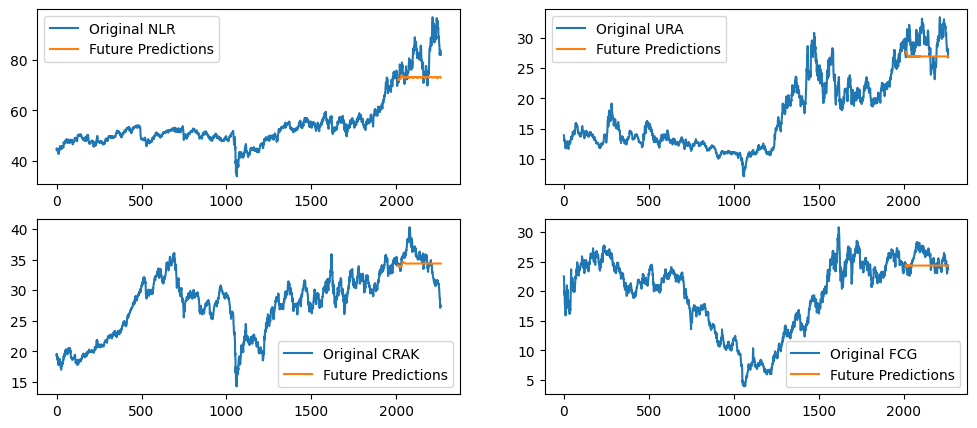

In [19]:
# 7 Show Results part 1
plt.figure(figsize=(12,5))
future_feature1 = np.squeeze(future1)
future_feature2 = np.squeeze(future2)
future_feature3 = np.squeeze(future3)
future_feature4 = np.squeeze(future4)
future_feature5 = np.squeeze(future5)
future_feature6 = np.squeeze(future6)
future_feature7 = np.squeeze(future7)
future_feature8 = np.squeeze(future8)
plt.subplot(2, 2, 1)
plt.plot(df_nlr['Close'], label="Original NLR")
plt.plot(range(2012, 2012 + len(future1)), future_feature1, label="Future Predictions")
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(df_ura['Close'], label="Original URA")
plt.plot(range(2012, 2012 + len(future2)), future_feature2, label="Future Predictions")
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(df_crak['Close'], label="Original CRAK")
plt.plot(range(2012, 2012 + len(future3)), future_feature3, label="Future Predictions")
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(df_fcg['Close'], label="Original FCG")
plt.plot(range(2012, 2012 + len(future4)), future_feature4, label="Future Predictions")
plt.legend()

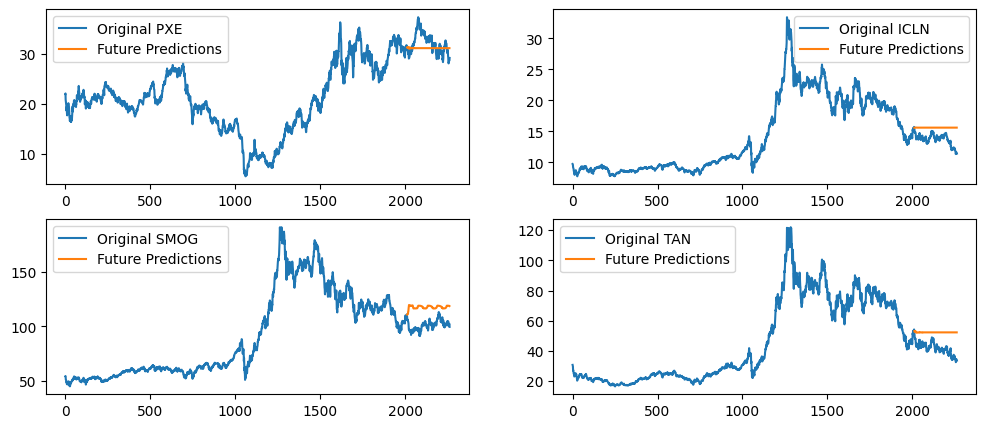

In [20]:
# 8 Show Results part 2
plt.figure(figsize=(12,5))
plt.subplot(2, 2, 1)
plt.plot(df_pxe['Close'], label="Original PXE")
plt.plot(range(2012, 2012 + len(future5)), future_feature5, label="Future Predictions")
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(df_icln['Close'], label="Original ICLN")
plt.plot(range(2012, 2012 + len(future6)), future_feature6, label="Future Predictions")
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(df_smog['Close'], label="Original SMOG")
plt.plot(range(2012, 2012 + len(future7)), future_feature7, label="Future Predictions")
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(df_tan['Close'], label="Original TAN")
plt.plot(range(2012, 2012 + len(future8)), future_feature8, label="Future Predictions")
plt.legend()

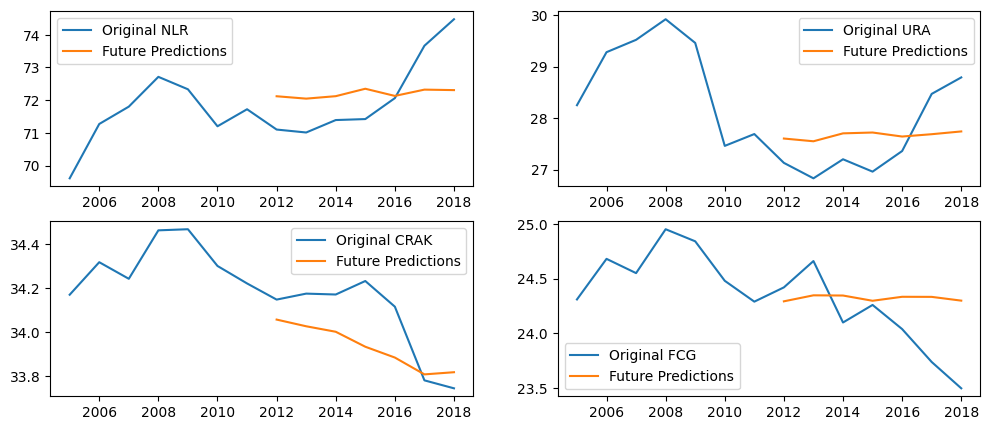

In [21]:
# 9 Show Results part 3
plt.figure(figsize=(12,5))
plt.subplot(2, 2, 1)
plt.plot(df_nlr['Close'].iloc[2005:2019], label="Original NLR")
plt.plot(range(2012, 2012 + 7), future_feature1[0:7], label="Future Predictions")
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(df_ura['Close'].iloc[2005:2019], label="Original URA")
plt.plot(range(2012, 2012 + 7), future_feature2[0:7], label="Future Predictions")
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(df_crak['Close'].iloc[2005:2019], label="Original CRAK")
plt.plot(range(2012, 2012 + 7), future_feature3[0:7], label="Future Predictions")
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(df_fcg['Close'].iloc[2005:2019], label="Original FCG")
plt.plot(range(2012, 2012 + 7), future_feature4[0:7], label="Future Predictions")
plt.legend()

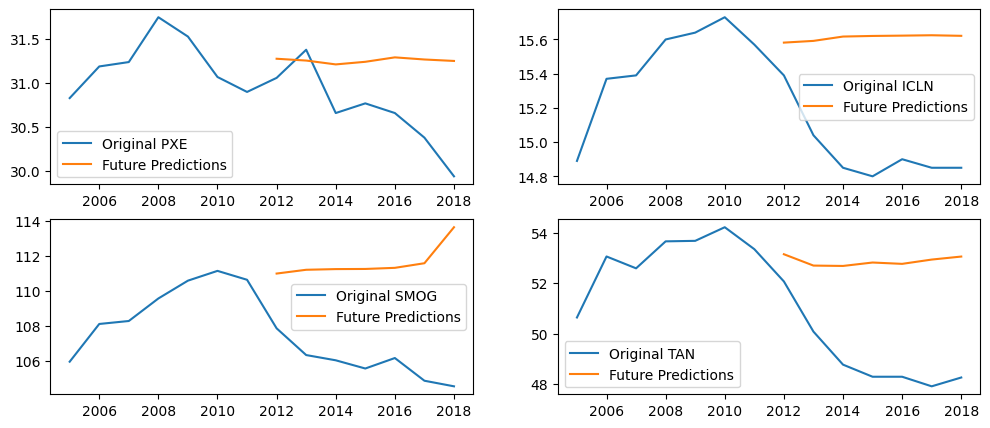

In [22]:
# 10 Show Results part 4
plt.figure(figsize=(12,5))
plt.subplot(2, 2, 1)
plt.plot(df_pxe['Close'].iloc[2005:2019], label="Original PXE")
plt.plot(range(2012, 2012 + 7), future_feature5[0:7], label="Future Predictions")
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(df_icln['Close'].iloc[2005:2019], label="Original ICLN")
plt.plot(range(2012, 2012 + 7), future_feature6[0:7], label="Future Predictions")
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(df_smog['Close'].iloc[2005:2019], label="Original SMOG")
plt.plot(range(2012, 2012 + 7), future_feature7[0:7], label="Future Predictions")
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(df_tan['Close'].iloc[2005:2019], label="Original TAN")
plt.plot(range(2012, 2012 + 7), future_feature8[0:7], label="Future Predictions")
plt.legend()

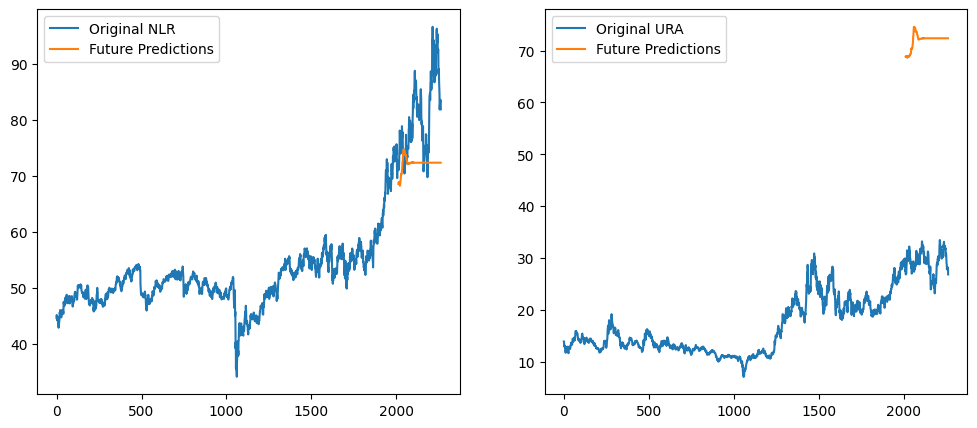

In [23]:
# 11 Combined Data Model Results part 1

plt.figure(figsize=(12,5))
future_feature_nuclear1 = np.squeeze(future_nuclear1)
future_feature_nuclear2 = np.squeeze(future_nuclear2)
future_feature_oilgas1 = np.squeeze(future_oilgas1)
future_feature_oilgas2 = np.squeeze(future_oilgas2)
future_feature_oilgas3 = np.squeeze(future_oilgas3)
future_feature_renewable1 = np.squeeze(future_renewable1)
future_feature_renewable2 = np.squeeze(future_renewable2)
future_feature_renewable3 = np.squeeze(future_renewable3)
plt.subplot(1, 2, 1)
plt.plot(df_nlr['Close'], label="Original NLR")
plt.plot(range(2012, 2012 + len(future_nuclear1)), future_feature_nuclear1, label="Future Predictions")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(df_ura['Close'], label="Original URA")
plt.plot(range(2012, 2012 + len(future_nuclear2)), future_feature_nuclear2, label="Future Predictions")
plt.legend()

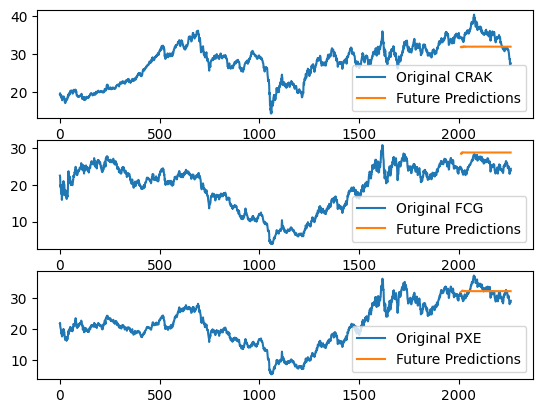

In [26]:
# 12 Combine Data Model results part 2
plt.subplot(3, 1, 1)
plt.plot(df_crak['Close'], label="Original CRAK")
plt.plot(range(2012, 2012 + len(future_oilgas1)), future_feature_oilgas1, label="Future Predictions")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(df_fcg['Close'], label="Original FCG")
plt.plot(range(2012, 2012 + len(future_oilgas2)), future_feature_oilgas2, label="Future Predictions")
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(df_pxe['Close'], label="Original PXE")
plt.plot(range(2012, 2012 + len(future_oilgas3)), future_feature_oilgas3, label="Future Predictions")
plt.legend()

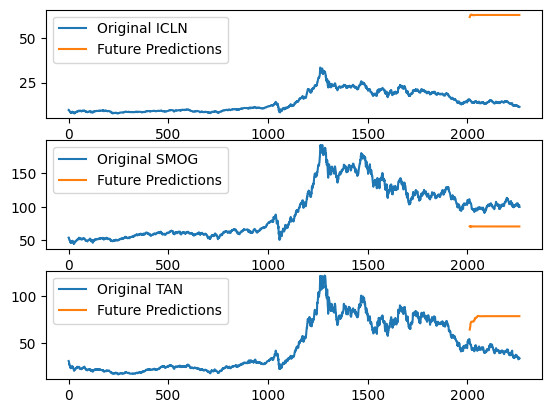

In [27]:
# 13 Combine Data Model results part 3
plt.subplot(3, 1, 1)
plt.plot(df_icln['Close'], label="Original ICLN")
plt.plot(range(2012, 2012 + len(future_renewable1)), future_feature_renewable1, label="Future Predictions")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(df_smog['Close'], label="Original SMOG")
plt.plot(range(2012, 2012 + len(future_renewable2)), future_feature_renewable2, label="Future Predictions")
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(df_tan['Close'], label="Original TAN")
plt.plot(range(2012, 2012 + len(future_renewable3)), future_feature_renewable3, label="Future Predictions")
plt.legend()

In [28]:
# 14 Alternative metric display
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
true_nlr = df_nlr_close.iloc[2012:2262]
true_ura = df_ura_close.iloc[2012:2262]
true_crak = df_crak_close.iloc[2012:2262]
true_fcg = df_fcg_close.iloc[2012:2262]
true_pxe = df_pxe_close.iloc[2012:2262]
true_icln = df_icln_close.iloc[2012:2262]
true_smog = df_smog_close.iloc[2012:2262]
true_tan = df_tan_close.iloc[2012:2262]

print("NLR Statistics")
mae = mean_absolute_error(true_nlr, future_feature1)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
mse = mean_squared_error(true_nlr, future_feature1)
print(f"Mean Squared Error (MSE): {mse:.4f}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
r2 = r2_score(true_nlr, future_feature1)
print(f"R-squared (R2): {r2:.4f}\n")

print("URA Statistics")
mae = mean_absolute_error(true_ura, future_feature2)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
mse = mean_squared_error(true_ura, future_feature2)
print(f"Mean Squared Error (MSE): {mse:.4f}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
r2 = r2_score(true_ura, future_feature2)
print(f"R-squared (R2): {r2:.4f}\n")

print("CRAK Statistics")
mae = mean_absolute_error(true_crak, future_feature3)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
mse = mean_squared_error(true_crak, future_feature3)
print(f"Mean Squared Error (MSE): {mse:.4f}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
r2 = r2_score(true_crak, future_feature3)
print(f"R-squared (R2): {r2:.4f}\n")

print("FCG Statistics")
mae = mean_absolute_error(true_fcg, future_feature4)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
mse = mean_squared_error(true_fcg, future_feature4)
print(f"Mean Squared Error (MSE): {mse:.4f}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
r2 = r2_score(true_fcg, future_feature4)
print(f"R-squared (R2): {r2:.4f}\n")

print("PXE Statistics")
mae = mean_absolute_error(true_pxe, future_feature5)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
mse = mean_squared_error(true_pxe, future_feature5)
print(f"Mean Squared Error (MSE): {mse:.4f}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
r2 = r2_score(true_pxe, future_feature5)
print(f"R-squared (R2): {r2:.4f}\n")

print("ICLN Statistics")
mae = mean_absolute_error(true_icln, future_feature6)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
mse = mean_squared_error(true_icln, future_feature6)
print(f"Mean Squared Error (MSE): {mse:.4f}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
r2 = r2_score(true_icln, future_feature6)
print(f"R-squared (R2): {r2:.4f}\n")

print("SMOG Statistics")
mae = mean_absolute_error(true_smog, future_feature7)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
mse = mean_squared_error(true_smog, future_feature7)
print(f"Mean Squared Error (MSE): {mse:.4f}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
r2 = r2_score(true_smog, future_feature7)
print(f"R-squared (R2): {r2:.4f}\n")

print("TAN Statistics")
mae = mean_absolute_error(true_tan, future_feature8)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
mse = mean_squared_error(true_tan, future_feature8)
print(f"Mean Squared Error (MSE): {mse:.4f}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
r2 = r2_score(true_tan, future_feature8)
print(f"R-squared (R2): {r2:.4f}")

NLR Statistics
Mean Absolute Error (MAE): 7.9619
Mean Squared Error (MSE): 105.1800
Root Mean Squared Error (RMSE): 10.2557
R-squared (R2): -1.2961

URA Statistics
Mean Absolute Error (MAE): 2.7726
Mean Squared Error (MSE): 10.0014
Root Mean Squared Error (RMSE): 3.1625
R-squared (R2): -1.0434

CRAK Statistics
Mean Absolute Error (MAE): 1.9167
Mean Squared Error (MSE): 6.0284
Root Mean Squared Error (RMSE): 2.4553
R-squared (R2): -0.0157

FCG Statistics
Mean Absolute Error (MAE): 1.4922
Mean Squared Error (MSE): 3.3206
Root Mean Squared Error (RMSE): 1.8222
R-squared (R2): -0.4757

PXE Statistics
Mean Absolute Error (MAE): 1.8132
Mean Squared Error (MSE): 5.2536
Root Mean Squared Error (RMSE): 2.2921
R-squared (R2): -0.1981

ICLN Statistics
Mean Absolute Error (MAE): 1.8911
Mean Squared Error (MSE): 4.2715
Root Mean Squared Error (RMSE): 2.0668
R-squared (R2): -5.1452

SMOG Statistics
Mean Absolute Error (MAE): 16.7810
Mean Squared Error (MSE): 305.1516
Root Mean Squared Error (RMSE): 